In [36]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.metrics import *
from sklearn.tree import *
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.linear_model import *
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import pickle

import warnings
warnings.filterwarnings('ignore')

# Reading the Dataset


In [37]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='03yO0bsVLbWiV58vRMK2NPTwU7w682n1I4dUQ4Qq3bY8',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'carresalevalueprediction-donotdelete-pr-zkjbbkyvfopsqb'
object_key = 'cardekho.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()

,full_name,selling_price,new_price,year,seller_type,km_driven,owner_type,fuel_type,transmission_type,mileage,engine,max_power,seats
0,Maruti Alto Std,1.2 Lakh*,NaN,2012,Individual,"1,20,000 kms",First Owner,Petrol,Manual,Mileage19.7 kmpl,Engine796 CC,Max Power46.3 bhp,Seats5
1,Hyundai Grand i10 Asta,5.5 Lakh*,New Car (On-Road Price) : Rs.7.11-7.48 Lakh*,2016,Individual,"20,000 kms",First Owner,Petrol,Manual,Mileage18.9 kmpl,Engine1197 CC,Max Power82 bhp,Seats5
2,Hyundai i20 Asta,2.15 Lakh*,NaN,2010,Individual,"60,000 kms",First Owner,Petrol,Manual,Mileage17.0 kmpl,Engine1197 CC,Max Power80 bhp,Seats5
3,Maruti Alto K10 2010-2014 VXI,2.26 Lakh*,NaN,2012,Individual,"37,000 kms",First Owner,Petrol,Manual,Mileage20.92 kmpl,Engine998 CC,Max Power67.1 bhp,Seats5
4,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,5.7 Lakh*,New Car (On-Road Price) : Rs.10.14-13.79 Lakh*,2015,Dealer,"30,000 kms",First Owner,Diesel,Manual,Mileage22.77 kmpl,Engine1498 CC,Max Power98.59 bhp,Seats5


# Checking NaN values

In [38]:
def null_count():
    return pd.DataFrame({'features': data.columns,
                'dtypes': data.dtypes.values,
                'NaN count': data.isnull().sum().values,
                'NaN percentage': data.isnull().sum().values/data.shape[0]}).style.background_gradient(cmap='Blues',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,full_name,object,0,0.000000
1,selling_price,object,0,0.000000
2,new_price,object,10410,0.521178
3,year,int64,0,0.000000
4,seller_type,object,0,0.000000
5,km_driven,object,0,0.000000
6,owner_type,object,0,0.000000
7,fuel_type,object,0,0.000000
8,transmission_type,object,0,0.000000
9,mileage,object,160,0.008010


# Cleaning the dataset

1.Cleaning selling price column(gettting only the numerical value and multipling by suffix value lakhs)

In [39]:
for i in range(data.shape[0]):
    try:
        price = float(data['selling_price'][i].split(' ')[0])
        digit = data['selling_price'][i].split(' ')[1]
        if digit == 'Lakh*':
            price = price * 100000
            data['selling_price'][i] = price
        elif digit == 'Cr*':
            price = price * 10000000
            data['selling_price'][i] = price
    except:
        price = data['selling_price'][i][:-1]
        price = price.replace(',', '')
        data['selling_price'][i] = float(price)
        
data.head()

,full_name,selling_price,new_price,year,seller_type,km_driven,owner_type,fuel_type,transmission_type,mileage,engine,max_power,seats
0,Maruti Alto Std,120000.0,NaN,2012,Individual,"1,20,000 kms",First Owner,Petrol,Manual,Mileage19.7 kmpl,Engine796 CC,Max Power46.3 bhp,Seats5
1,Hyundai Grand i10 Asta,550000.0,New Car (On-Road Price) : Rs.7.11-7.48 Lakh*,2016,Individual,"20,000 kms",First Owner,Petrol,Manual,Mileage18.9 kmpl,Engine1197 CC,Max Power82 bhp,Seats5
2,Hyundai i20 Asta,215000.0,NaN,2010,Individual,"60,000 kms",First Owner,Petrol,Manual,Mileage17.0 kmpl,Engine1197 CC,Max Power80 bhp,Seats5
3,Maruti Alto K10 2010-2014 VXI,226000.0,NaN,2012,Individual,"37,000 kms",First Owner,Petrol,Manual,Mileage20.92 kmpl,Engine998 CC,Max Power67.1 bhp,Seats5
4,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,570000.0,New Car (On-Road Price) : Rs.10.14-13.79 Lakh*,2015,Dealer,"30,000 kms",First Owner,Diesel,Manual,Mileage22.77 kmpl,Engine1498 CC,Max Power98.59 bhp,Seats5


2.Cleaning kilometer driven, Mileage, Engine, Maxpower and Seats columns (getting only the numerical values from those strings)

In [40]:
# kilometer driven
data['km_driven'] = data['km_driven'].str.split(' ', n=1, expand=True)[0]
data['km_driven'] = data['km_driven'].str.replace(',','')
# Mileage
data['mileage'] = data['mileage'].str.split(' ', expand=True)[0].str.split('e', expand=True)[2]
# Engine
data['engine'] = data['engine'].str.split(' ', expand=True)[0].str.split('e',expand=True)[1]
# Max Power
data['max_power'] = data['max_power'].str.split(' ', expand=True)[1].str.split('r',expand=True)[1]
# Seats 
data['seats'] = data['seats'].str.split('s', expand=True)[1]

data.head()

,full_name,selling_price,new_price,year,seller_type,km_driven,owner_type,fuel_type,transmission_type,mileage,engine,max_power,seats
0,Maruti Alto Std,120000.0,NaN,2012,Individual,120000,First Owner,Petrol,Manual,19.7,796,46.3,5
1,Hyundai Grand i10 Asta,550000.0,New Car (On-Road Price) : Rs.7.11-7.48 Lakh*,2016,Individual,20000,First Owner,Petrol,Manual,18.9,1197,82,5
2,Hyundai i20 Asta,215000.0,NaN,2010,Individual,60000,First Owner,Petrol,Manual,17.0,1197,80,5
3,Maruti Alto K10 2010-2014 VXI,226000.0,NaN,2012,Individual,37000,First Owner,Petrol,Manual,20.92,998,67.1,5
4,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,570000.0,New Car (On-Road Price) : Rs.10.14-13.79 Lakh*,2015,Dealer,30000,First Owner,Diesel,Manual,22.77,1498,98.59,5


3.Changing the data types of the columns(data types of the feaures such as selling_price, km_driven, mileage, engine, max_power, seats to int/float)

In [41]:
cols = ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']

for col in cols:
    try:
        data[col] = data[col].astype(int)
    except:
        data[col] = data[col].astype(float)
data.head()

,full_name,selling_price,new_price,year,seller_type,km_driven,owner_type,fuel_type,transmission_type,mileage,engine,max_power,seats
0,Maruti Alto Std,120000,NaN,2012,Individual,120000,First Owner,Petrol,Manual,19.70,796.0,46.30,5.0
1,Hyundai Grand i10 Asta,550000,New Car (On-Road Price) : Rs.7.11-7.48 Lakh*,2016,Individual,20000,First Owner,Petrol,Manual,18.90,1197.0,82.00,5.0
2,Hyundai i20 Asta,215000,NaN,2010,Individual,60000,First Owner,Petrol,Manual,17.00,1197.0,80.00,5.0
3,Maruti Alto K10 2010-2014 VXI,225999,NaN,2012,Individual,37000,First Owner,Petrol,Manual,20.92,998.0,67.10,5.0
4,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,570000,New Car (On-Road Price) : Rs.10.14-13.79 Lakh*,2015,Dealer,30000,First Owner,Diesel,Manual,22.77,1498.0,98.59,5.0


4.Creating new feature Company(from full_name by getting the first word which is actually the cars company)

In [42]:
data['company'] = data['full_name'].str.split(' ', expand=True)[0]
data.head()

,full_name,selling_price,new_price,year,seller_type,km_driven,owner_type,fuel_type,transmission_type,mileage,engine,max_power,seats,company
0,Maruti Alto Std,120000,NaN,2012,Individual,120000,First Owner,Petrol,Manual,19.70,796.0,46.30,5.0,Maruti
1,Hyundai Grand i10 Asta,550000,New Car (On-Road Price) : Rs.7.11-7.48 Lakh*,2016,Individual,20000,First Owner,Petrol,Manual,18.90,1197.0,82.00,5.0,Hyundai
2,Hyundai i20 Asta,215000,NaN,2010,Individual,60000,First Owner,Petrol,Manual,17.00,1197.0,80.00,5.0,Hyundai
3,Maruti Alto K10 2010-2014 VXI,225999,NaN,2012,Individual,37000,First Owner,Petrol,Manual,20.92,998.0,67.10,5.0,Maruti
4,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,570000,New Car (On-Road Price) : Rs.10.14-13.79 Lakh*,2015,Dealer,30000,First Owner,Diesel,Manual,22.77,1498.0,98.59,5.0,Ford


5.Dropping Unwanted Coloumns(such as full_name,new_price,owner_type)

In [43]:
data.drop(columns=['new_price','owner_type','max_power','seats',
                  'seller_type'], axis=1, inplace=True)
data.head()

,full_name,selling_price,year,km_driven,fuel_type,transmission_type,mileage,engine,company
0,Maruti Alto Std,120000,2012,120000,Petrol,Manual,19.70,796.0,Maruti
1,Hyundai Grand i10 Asta,550000,2016,20000,Petrol,Manual,18.90,1197.0,Hyundai
2,Hyundai i20 Asta,215000,2010,60000,Petrol,Manual,17.00,1197.0,Hyundai
3,Maruti Alto K10 2010-2014 VXI,225999,2012,37000,Petrol,Manual,20.92,998.0,Maruti
4,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,570000,2015,30000,Diesel,Manual,22.77,1498.0,Ford


# Data Analysis (Vizualization)

1.Basic statistic on numerical features

In [44]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
selling_price,19974.0,739294.432612,910400.116520,25000.0,340000.00,520000.0,785000.00,39500000.0
year,19974.0,2014.526134,3.248791,1991.0,2013.00,2015.0,2017.00,2021.0
km_driven,19974.0,58238.894663,51727.595500,100.0,31114.00,52000.0,74000.00,3800000.0
mileage,19814.0,19.503637,4.298090,4.0,16.95,19.3,22.32,120.0
engine,19864.0,1477.805981,519.843056,72.0,1197.00,1248.0,1582.00,6752.0


2.Basic statistics on categorical features

In [45]:
data.describe(include='O')

,full_name,fuel_type,transmission_type,company
count,19974,19974,19974,19974
unique,3321,5,2,42
top,Maruti Swift Dzire VDI,Diesel,Manual,Maruti
freq,210,9815,16025,5648


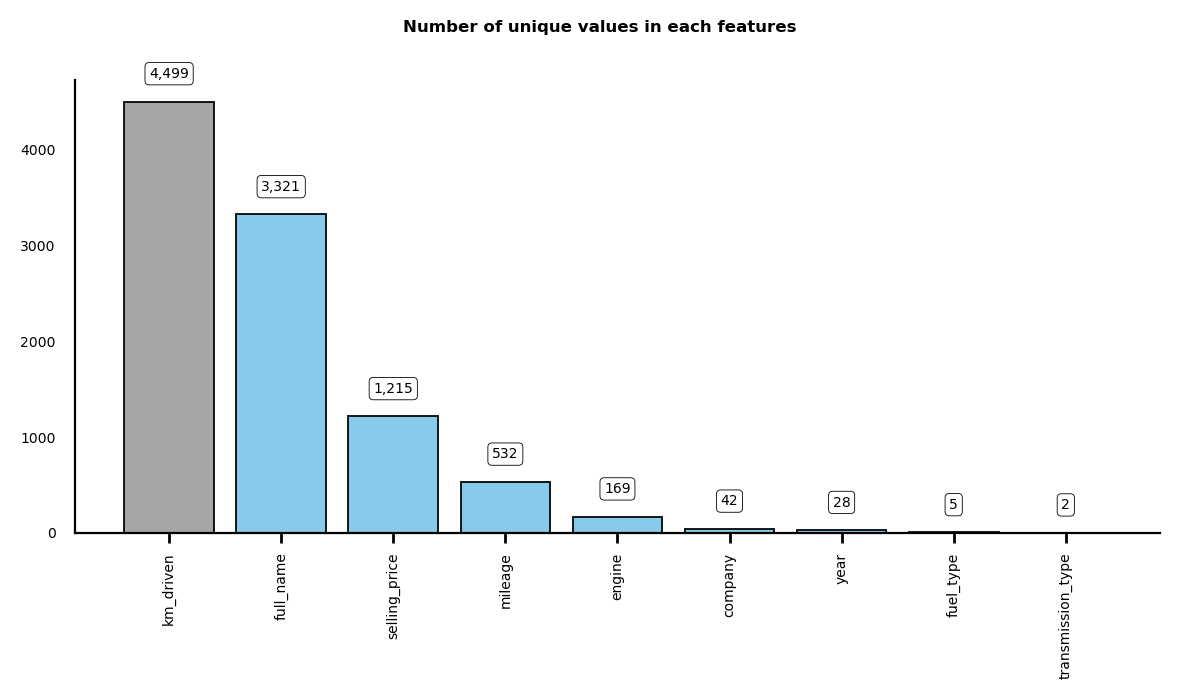

In [46]:
x = data.nunique().sort_values(ascending=False).index
y = data.nunique().sort_values(ascending=False).values

plt.rcParams['figure.dpi'] = 200
fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)
ax0 = fig.add_subplot(gs[0,0])
for i in ['top', 'right']:
    ax0.spines[i].set_visible(False)
    
colormap = ['#79c6e8' for i in range(data.shape[1])]
colormap[0] = '#9c9a9a'

ax0.bar(x=x, height=y, edgecolor='k', linewidth=0.7, color=colormap, alpha=0.9)
ax0.tick_params(axis='x',labelsize=5, rotation=90, width=1)
ax0.tick_params(axis='y', labelsize=5, left=False)
fig.suptitle(t='Number of unique values in each features', fontsize=6, weight='bold')

for p in ax0.patches:
    value = f'{p.get_height():,.0f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()+290
    ax0.text(x, y, value, ha='center', va='center', fontsize=5, 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', linewidth=0.3))
plt.show()

# Feature engineering

1.Imputing missing values

In [47]:
null_count()


,features,dtypes,NaN count,NaN percentage
0,full_name,object,0,0.000000
1,selling_price,int64,0,0.000000
2,year,int64,0,0.000000
3,km_driven,int64,0,0.000000
4,fuel_type,object,0,0.000000
5,transmission_type,object,0,0.000000
6,mileage,float64,160,0.008010
7,engine,float64,110,0.005507
8,company,object,0,0.000000


In [48]:
for i in ['mileage', 'engine']:
    company_name = data[data[i].isnull()]['company'].value_counts().index[0]
    if data[i].nunique()>10:
        values = data[data['company']==company_name][i].mean()
    else:
        values = data[data['company']==company_name][i].median()
        
    data[i].fillna(values, inplace=True)
    
null_count()

,features,dtypes,NaN count,NaN percentage
0,full_name,object,0,0.000000
1,selling_price,int64,0,0.000000
2,year,int64,0,0.000000
3,km_driven,int64,0,0.000000
4,fuel_type,object,0,0.000000
5,transmission_type,object,0,0.000000
6,mileage,float64,0,0.000000
7,engine,float64,0,0.000000
8,company,object,0,0.000000


2. Removing outliers in the data

In [49]:
data = data[data['selling_price'] < 20000000]
data=data[data['selling_price']<6000000]
data = data[data['km_driven'] < 1000000]
data = data[data['mileage'] < 100]
data = data[data['engine'] < 6100]
data = data.reset_index(drop=True)

3.Appling discretization on company

In [50]:
company_name = data.company.value_counts().index[:15]
for i in range(data.shape[0]):
    if data['company'][i] in company_name:
         continue
    else:
        data['company'][i] = 'others'

In [51]:
#Checking Before Encoding Categorical Variables

data.head()

#renaming full_name to name
data.rename(columns = {'full_name':'name'}, inplace = True)

data.head()

,name,selling_price,year,km_driven,fuel_type,transmission_type,mileage,engine,company
0,Maruti Alto Std,120000,2012,120000,Petrol,Manual,19.70,796.0,Maruti
1,Hyundai Grand i10 Asta,550000,2016,20000,Petrol,Manual,18.90,1197.0,Hyundai
2,Hyundai i20 Asta,215000,2010,60000,Petrol,Manual,17.00,1197.0,Hyundai
3,Maruti Alto K10 2010-2014 VXI,225999,2012,37000,Petrol,Manual,20.92,998.0,Maruti
4,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,570000,2015,30000,Diesel,Manual,22.77,1498.0,Ford


# Final Adjustments Before Splitting the dataset for Model Builing

In [52]:
#Renaming price coloumn and km_driven
data = data.rename(columns={'selling_price': 'Price'})
data = data.rename(columns={'km_driven': 'kms_driven'})

#Taking only 1st 3 names of the car model
data['name']=data['name'].str.split().str.slice(start=0,stop=3).str.join(' ')

data.head()

,name,Price,year,kms_driven,fuel_type,transmission_type,mileage,engine,company
0,Maruti Alto Std,120000,2012,120000,Petrol,Manual,19.70,796.0,Maruti
1,Hyundai Grand i10,550000,2016,20000,Petrol,Manual,18.90,1197.0,Hyundai
2,Hyundai i20 Asta,215000,2010,60000,Petrol,Manual,17.00,1197.0,Hyundai
3,Maruti Alto K10,225999,2012,37000,Petrol,Manual,20.92,998.0,Maruti
4,Ford Ecosport 2015-2021,570000,2015,30000,Diesel,Manual,22.77,1498.0,Ford


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19878 entries, 0 to 19877
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               19878 non-null  object 
 1   Price              19878 non-null  int64  
 2   year               19878 non-null  int64  
 3   kms_driven         19878 non-null  int64  
 4   fuel_type          19878 non-null  object 
 5   transmission_type  19878 non-null  object 
 6   mileage            19878 non-null  float64
 7   engine             19878 non-null  float64
 8   company            19878 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 1.4+ MB


In [54]:
#Changing mielage and engine coloumn to int
data['mileage']=data['mileage'].astype(int)
data['engine']=data['engine'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19878 entries, 0 to 19877
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               19878 non-null  object
 1   Price              19878 non-null  int64 
 2   year               19878 non-null  int64 
 3   kms_driven         19878 non-null  int64 
 4   fuel_type          19878 non-null  object
 5   transmission_type  19878 non-null  object
 6   mileage            19878 non-null  int64 
 7   engine             19878 non-null  int64 
 8   company            19878 non-null  object
dtypes: int64(5), object(4)
memory usage: 1.4+ MB


In [55]:
data.drop(['mileage', 'engine','transmission_type'], axis = 1, inplace = True)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19878 entries, 0 to 19877
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        19878 non-null  object
 1   Price       19878 non-null  int64 
 2   year        19878 non-null  int64 
 3   kms_driven  19878 non-null  int64 
 4   fuel_type   19878 non-null  object
 5   company     19878 non-null  object
dtypes: int64(3), object(3)
memory usage: 931.9+ KB


#Saving Cleaned Dataset

In [57]:
data.to_csv('Cleaned.csv')

# Extracting Training Data

In [58]:
X=data[['name','company','year','kms_driven','fuel_type']]
y=data['Price']

In [59]:
X

,name,company,year,kms_driven,fuel_type
0,Maruti Alto Std,Maruti,2012,120000,Petrol
1,Hyundai Grand i10,Hyundai,2016,20000,Petrol
2,Hyundai i20 Asta,Hyundai,2010,60000,Petrol
3,Maruti Alto K10,Maruti,2012,37000,Petrol
4,Ford Ecosport 2015-2021,Ford,2015,30000,Diesel
...,...,...,...,...,...
19873,Maruti A Star,Maruti,2009,15000,Petrol
19874,Toyota Platinum Etios,Toyota,2017,69480,Diesel
19875,Maruti Ertiga BSIV,Maruti,2019,18000,Petrol
19876,Skoda Rapid 1.5,Skoda,2015,67000,Diesel


In [60]:
y.shape

(19878,)

# Applying Train Test Split

In [61]:
from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=i)

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

# Creating an OneHotEncoder object to contain all the possible categories

In [62]:
ohe=OneHotEncoder()
ohe.fit(X[['name','company','fuel_type']])

OneHotEncoder()

# Creating a column transformer to transform categorical columns

In [63]:
column_trans=make_column_transformer((OneHotEncoder(categories=ohe.categories_),['name','company','fuel_type']),
                                    remainder='passthrough')

# Selecting RandomForest Model

In [64]:
rr=RandomForestRegressor()

#Making a pipeline

In [65]:
pipe=make_pipeline(column_trans,rr)

#Fitting the model

In [66]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['Ambassador Avigo 1800', 'Ambassador Avigo 2000',
       'Ambassador Classic 1800', 'Ambassador Classic 2000', 'Audi A3 35',
       'Audi A3 40', 'Audi A3 cabriolet', 'Audi A4 1.8', 'Audi A4 2.0',
       'Audi A4 2008-2014', 'Audi A4 3.0', 'Audi A4 30', 'Audi A4 35'...
       'Volvo XC90 D5'], dtype=object),
                                                                            array(['Audi', 'BMW', 'Chevrolet', 'Ford', 'Honda', 'Hyundai', 'Mahindra',
       'Maruti', 'Mercedes-Benz', 'Nissan', 'Renault', 'Skoda', 'Tata',
       'Toyota', 'Volkswagen', 'others'], dtype=object),
                                                                            array(['CNG', 'Diesel', 'Electric', 'LPG', 'Petrol'], dtype=object)]),
               

In [67]:
y_pred=pipe.predict(X_test)

#Checking R2 Score

In [68]:
r2_score(y_test,y_pred)

0.905431824868707

#Final Model(RandomForest)

In [69]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=i)
rr=RandomForestRegressor()
pipe=make_pipeline(column_trans,rr)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_test)
print(r2_score(y_test,y_pred))

0.9051466925424294


#Testing For Price

In [70]:
pipe.predict(pd.DataFrame(columns=X_test.columns,data=np.array(['Hyundai Grand i10','Hyundai',2018,40000,'Petrol']).reshape(1,5)))

array([510266.62333333])

Savin the Model to a Pickle File

In [71]:
import pickle
pickle.dump(pipe,open('RandomForest.pkl','wb'))

In [72]:
pipe.predict(pd.DataFrame(columns=['name','company','year','kms_driven','fuel_type'],data=np.array(['Hyundai Grand i10','Hyundai',2018,40000,'Petrol']).reshape(1,5)))

array([510266.62333333])

In [73]:
pipe.steps[0][1].transformers[0][1].categories[0]

array(['Ambassador Avigo 1800', 'Ambassador Avigo 2000',
       'Ambassador Classic 1800', 'Ambassador Classic 2000', 'Audi A3 35',
       'Audi A3 40', 'Audi A3 cabriolet', 'Audi A4 1.8', 'Audi A4 2.0',
       'Audi A4 2008-2014', 'Audi A4 3.0', 'Audi A4 30', 'Audi A4 35',
       'Audi A4 New', 'Audi A5 Sportback', 'Audi A6 2.0', 'Audi A6 2.7',
       'Audi A6 2.8', 'Audi A6 3.0', 'Audi A6 35', 'Audi A6 45',
       'Audi A8 4.2', 'Audi A8 L', 'Audi Q3 2.0', 'Audi Q3 2015-2017',
       'Audi Q3 30', 'Audi Q3 35', 'Audi Q5 2.0', 'Audi Q5 3.0',
       'Audi Q5 30', 'Audi Q5 40', 'Audi Q7 2006-2020', 'Audi R8 4.2',
       'Audi S4 3.0', 'Audi S5 Sportback', 'Audi TT Coupe',
       'BMW 1 Series', 'BMW 3 Series', 'BMW 5 Series', 'BMW 6 Series',
       'BMW 7 Series', 'BMW M Series', 'BMW X1 sDrive',
       'BMW X1 sDrive20d', 'BMW X1 xDrive', 'BMW X3 2.0d', 'BMW X3 3.0d',
       'BMW X3 xDrive', 'BMW X3 xDrive20d', 'BMW X3 xDrive30d',
       'BMW X4 M', 'BMW X5 3.0d', 'BMW X5 xDrive', 'BMW

# Deployin ML model in cloud

In [74]:
!pip install ibm_watson_machine_learning

In [87]:
from ibm_watson_machine_learning import APIClient
#import json
#import numpy as np

In [76]:
wml_credentials = {
    'apikey' : "_VdiGGVE2riXwMsv4Otfb1PoHBp7TgTkxl0ff__UheDS",
    "url" : "https://us-south.ml.cloud.ibm.com"
}

In [77]:
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ----------------  ------------------------
ID                                    NAME              CREATED
3f5f8e9e-ee76-46da-94a6-226d0af122da  Car Resale Model  2022-11-18T07:57:05.333Z
------------------------------------  ----------------  ------------------------


In [78]:
space_id = "3f5f8e9e-ee76-46da-94a6-226d0af122da"

In [79]:
wml_client.set.default_space(space_id)

'SUCCESS'

In [80]:
wml_client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [89]:
model_name = "resale_model"
deployment_name = "Car Resale Model"
model_deploy = pipe

In [90]:
software_spec_uid = wml_client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")

In [91]:
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [93]:
client = APIClient(wml_credentials)
model_props={
  client.repository.ModelMetaNames.NAME : model_name,
  client.repository.ModelMetaNames.TYPE:"scikit-learn_1.0",
  client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

In [94]:
model_details = wml_client.repository.store_model(
    model = model_deploy,
    meta_props = model_props,
    training_data = X_train,
    training_target = y_train)

In [95]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'Price',
  'schemas': {'input': [{'fields': [{'name': 'name', 'type': 'object'},
      {'name': 'company', 'type': 'object'},
      {'name': 'year', 'type': 'int64'},
      {'name': 'kms_driven', 'type': 'int64'},
      {'name': 'fuel_type', 'type': 'object'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-11-18T08:23:49.143Z',
  'id': '876e6773-8919-4e17-87a1-bcb79f6448a6',
  'modified_at': '2022-11-18T08:24:26.777Z',
  'name': 'resale_model',
  'owner': 'IBMid-6610046I9X',
  'resource_key': 'e7ca9549-a542-494b-a843-53b4e4ea49ce',
  'space_id': '3f5f8e9e-ee76-46da-94a6-226d0af122da'},
 'system': {'warnings': []}}

In [101]:


import requests

# NOTE: you must manually set API_KEY below using information retrieved from your IBM Cloud account.
API_KEY = "_VdiGGVE2riXwMsv4Otfb1PoHBp7TgTkxl0ff__UheDS"
token_response = requests.post('https://iam.cloud.ibm.com/identity/token', data={"apikey":
 API_KEY, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line

payload_scoring = {"input_data": [{"fields": ['name', 'company', 'year', 'kms_driven', 'fuel_type'], "values": [['Hyundai Grand i10','Hyundai',2018,40000,'Petrol'] ]}]}

response_scoring = requests.post('https://us-south.ml.cloud.ibm.com/ml/v4/deployments/0a769d98-9edf-4e48-bf5c-f371da57233b/predictions?version=2022-11-18', json=payload_scoring,
 headers={'Authorization': 'Bearer ' + mltoken})
print("Scoring response")
print(response_scoring.json())

Scoring response
{'predictions': [{'fields': ['prediction'], 'values': [[510266.6233333333]]}]}
